# 🏎️📊 **Proyecto Machine Learning Fórmula 1 (Kedro + CRISP-DM)**
## 🧠 Notebook de Modelado — **Clasificación** (Evaluación Parcial 2)

<div style="margin-top:10px; padding:12px 14px; border-left:8px solid #7c3aed; background:#0b1220; color:#e5e7eb; border-radius:12px;">
<b>Autor:</b> Ignacio Retamales <br>
<b>Asignatura:</b> Machine Learning — Evaluación 2 <br>
<b>Dataset:</b> Formula 1 World Championship (1950–2024) — Kaggle <br>
<b>Fecha:</b> <i>(completar)</i>
</div>

---

## 🎯 Propósito académico del notebook
Este notebook documenta, de forma **técnica, reproducible y defendible**, el proceso completo de **entrenamiento, comparación, selección y evaluación** de modelos de **clasificación binaria**, siguiendo buenas prácticas de experimentación:

✅ *pipeline reproducible* (artefactos persistidos: métricas/tabla/modelo)  
✅ validación cruzada estratificada (**k-fold, k ≥ 5**)  
✅ comparación **multi-métrica** (Accuracy, Precision, Recall, F1 macro)  
✅ señal de generalización (**gap train vs CV**)  
✅ evaluación final en **hold-out test** y visualizaciones interpretables  

---

## 🧩 Definición del Target (Clasificación)
Se define el target discreto:

- **target_cls = 1** si `points > 0`  
- **target_cls = 0** si `points == 0`

📌 Interpretación operacional: **“¿El piloto logra puntuar en la carrera?”**

---

## 🧠 Hipótesis de modelado (intuición técnica)
La capacidad predictiva proviene de combinar:

- **variables pre-carrera** (sin fuga de información / leakage)  
- **features históricas desfasadas** (*shift + expanding/rolling*), que capturan:
  - consistencia histórica del piloto,
  - competitividad del constructor,
  - efecto del circuito,
  - contexto temporal (año / ronda).

---

## 🧪 ¿Qué significa “sin leakage” aquí?
Para garantizar validez, **no se utilizan variables conocidas después de la carrera**, por ejemplo:
- tiempo final (`milliseconds`)
- posición final (`position`, `positionOrder`)
- vueltas (`laps`)
- puntos (`points`)
- cualquier atributo que sea consecuencia directa del resultado

➡️ El modelo aprende *solo* con información que existiría **antes** de iniciar la carrera.

---

## 📦 Artefactos consumidos en este notebook
Este notebook utiliza artefactos generados por Kedro (persistidos en `/data`):

- `data/05_model_input/model_input_classification.csv`  
- `data/08_reporting/classification_metrics_table.csv`  
- `data/08_reporting/classification_metrics_summary.json`  
- `data/06_models/best_model_classification.pkl`  
- *(opcional)* `data/08_reporting/classification_metrics.png`

---

## 🗺️ Convención de lectura (para evaluación y defensa)
- **Markdown:** contexto, justificación técnica e interpretación  
- **Código:** ejecución reproducible + trazas (✅/ℹ️/⚠️)  
- **Conclusiones:** siempre al final de cada bloque relevante (con evidencia numérica)  

---

> **Meta de rendimiento (según exigencia):** alcanzar y justificar un desempeño ≥ **0.87** (según métrica definida por la rúbrica / docente).


## 🧭 Guía de lectura rápida
1. **Carga Kedro + Catalog**  
2. **Carga outputs oficiales del pipeline**  
3. **Comparación de modelos (CV)**  
4. **Validaciones y consistencia**  
5. **Visualizaciones del mejor modelo**  
6. **Conclusiones (cuando me entregues los outputs finales)** 


In [1]:
from __future__ import annotations

from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display, HTML

def banner(title: str, subtitle: str | None = None, color: str = "#2563eb"):
    subtitle_html = f"<div style='opacity:.85;font-size:14px;margin-top:4px'>{subtitle}</div>" if subtitle else ""
    html = f"""
    <div style="
        border-left: 10px solid {color};
        background: #0b1220;
        color: #e5e7eb;
        padding: 14px 16px;
        border-radius: 12px;
        margin: 10px 0 14px 0;
        font-family: ui-sans-serif, system-ui;">
        <div style="font-size:18px;font-weight:700;">{title}</div>
        {subtitle_html}
    </div>
    """
    display(HTML(html))

def ok(msg: str):
    display(HTML(f"<div style='padding:10px 12px;border-radius:10px;background:#052e16;color:#d1fae5;border:1px solid #14532d'>✅ {msg}</div>"))

def info(msg: str):
    display(HTML(f"<div style='padding:10px 12px;border-radius:10px;background:#0b1220;color:#e5e7eb;border:1px solid #1f2937'>ℹ️ {msg}</div>"))

def warn(msg: str):
    display(HTML(f"<div style='padding:10px 12px;border-radius:10px;background:#2b1d0e;color:#fde68a;border:1px solid #92400e'>⚠️ {msg}</div>"))

banner("🧩 Setup del Notebook", "Imports + utilidades visuales (sin depender de KedroContext/DataCatalog)", "#7c3aed")
ok("Setup listo. Este notebook será estable leyendo artefactos desde /data.")


In [2]:
banner("🧭 Resolución de rutas", "Detectar raíz del proyecto y ubicar /data de forma robusta", "#22c55e")

# Intento 1: si estás dentro de /notebooks, la raíz suele ser parent
CWD = Path.cwd()

# Heurística: buscamos conf/base o pyproject.toml para encontrar raíz
def find_project_root(start: Path) -> Path:
    cur = start
    for _ in range(6):
        if (cur / "conf" / "base").exists() or (cur / "pyproject.toml").exists():
            return cur
        cur = cur.parent
    return start

PROJECT_ROOT = find_project_root(CWD)
DATA_DIR = PROJECT_ROOT / "data"

info(f"📌 CWD: {CWD}")
info(f"🏁 PROJECT_ROOT detectado: {PROJECT_ROOT}")
info(f"🗂️ DATA_DIR: {DATA_DIR}")

if not DATA_DIR.exists():
    warn("No encuentro la carpeta /data en PROJECT_ROOT. Revisa dónde estás ejecutando el notebook.")
else:
    ok("Rutas OK. Continuamos con carga de artefactos.")


# 📦 Carga segura de artefactos

En esta sección se cargan directamente desde la carpeta `/data` los artefactos del pipeline de clasificación.

✅ Ventajas de este enfoque:
- evita dependencias de `KedroContext/DataCatalog` dentro del notebook  
- reduce riesgos de incompatibilidad de versión  
- permite reproducibilidad inmediata usando resultados persistidos  

📌 Artefactos clave:
- **Tabla comparativa de modelos** (CV + test)
- **Resumen JSON** (métrica objetivo + mejor modelo + configuración)
- **Dataset de entrada** (`model_input_classification`)
- **Modelo final** (`best_model_classification.pkl`)


In [3]:
banner("📦 Carga de artefactos (Clasificación)", "Leemos CSV/JSON/PKL desde data/ (modo seguro)", "#f59e0b")

paths = {
    "metrics_summary": DATA_DIR / "08_reporting" / "classification_metrics_summary.json",
    "metrics_table":   DATA_DIR / "08_reporting" / "classification_metrics_table.csv",
    "model_input":     DATA_DIR / "05_model_input" / "model_input_classification.csv",
    "best_model":      DATA_DIR / "06_models" / "best_model_classification.pkl",
    "metrics_png":     DATA_DIR / "08_reporting" / "classification_metrics.png",
}

for k, p in paths.items():
    if p.exists():
        ok(f"{k}: encontrado ✅ → {p}")
    else:
        warn(f"{k}: NO encontrado ❌ → {p}")

# Carga de JSON + CSV (si existen)
summary = None
table = None
df_cls = None

if paths["metrics_summary"].exists():
    summary = json.loads(paths["metrics_summary"].read_text(encoding="utf-8"))
    ok("classification_metrics_summary.json cargado.")

if paths["metrics_table"].exists():
    table = pd.read_csv(paths["metrics_table"])
    ok("classification_metrics_table.csv cargado.")

if paths["model_input"].exists():
    df_cls = pd.read_csv(paths["model_input"])
    ok("model_input_classification.csv cargado.")

info("Si falta algún artefacto, ejecuta el pipeline de clasificación en Kedro y vuelve a correr esta celda.")


# ✅ Resultados principales
En esta sección se presenta:

- 🧪 **Desempeño en validación cruzada (k-fold estratificado)**  
- 🧾 **Comparación de modelos** (accuracy, precision_macro, recall_macro, f1_macro)  
- 🏆 **Selección del mejor modelo** según criterio definido (por defecto: *F1 macro*)  
- 📌 **Evaluación final en hold-out test**  
- 🔍 **Análisis de estabilidad** (std en CV) y señal de overfitting (generalization gap)

> En la discusión final interpretaremos por qué el modelo funciona, qué errores comete y cómo se justifica técnicamente su elección.


In [4]:
banner("🏁 Métricas resumidas + Tabla comparativa", "Lectura directa desde artefactos del pipeline", "#3b82f6")

if summary is None:
    warn("No hay summary cargado. Revisa si existe el JSON en data/08_reporting.")
else:
    display(pd.json_normalize(summary))

if table is None:
    warn("No hay tabla cargada. Revisa si existe el CSV en data/08_reporting.")
else:
    # Ordenar por CV F1 macro (o la métrica que tú quieras)
    sort_col = "cv_f1_macro_mean" if "cv_f1_macro_mean" in table.columns else table.columns[0]
    table_sorted = table.sort_values(sort_col, ascending=False).reset_index(drop=True)

    info(f"Tabla ordenada por: {sort_col}")
    display(table_sorted.head(10))
    ok("Tabla comparativa mostrada (Top-10).")


,selection_criterion,best_model,best_params,models_compared,notes,cv.folds,cv.best_accuracy_mean,cv.best_accuracy_std,cv.best_precision_macro_mean,cv.best_precision_macro_std,...,data_split.random_state,data_split.n_train,data_split.n_test,data_split.class_balance_train.0,data_split.class_balance_train.1,data_split.class_balance_test.0,data_split.class_balance_test.1,smote.enabled_global,smote.k_neighbors,smote.note
0,cv_f1_macro_mean,hgb,"{'model__l2_regularization': 1.0, 'model__lear...","[hgb, gb, rf, extra_trees, svc, logreg, knn]",[Se usa StratifiedKFold (k>=5) para preservar ...,5,0.904378,0.008939,0.902394,0.009595,...,42,8063,2016,0.569639,0.430361,0.569444,0.430556,True,5,SMOTE se aplica dentro del pipeline (por fold)...


,model,use_smote,best_params,cv_accuracy_mean,cv_accuracy_std,cv_precision_macro_mean,cv_precision_macro_std,cv_recall_macro_mean,cv_recall_macro_std,cv_f1_macro_mean,cv_f1_macro_std,train_f1_macro_mean,generalization_gap_f1,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro
0,hgb,False,"{'model__l2_regularization': 1.0, 'model__lear...",0.904378,0.008939,0.902394,0.009595,0.902857,0.008359,0.902566,0.008962,1.000000,0.097434,0.916667,0.915321,0.914606,0.914955
1,gb,False,"{'model__learning_rate': 0.1, 'model__max_dept...",0.869157,0.015041,0.866472,0.015607,0.867114,0.014705,0.866722,0.015164,0.928518,0.061796,0.874504,0.871758,0.872668,0.872195
2,rf,True,"{'model__max_depth': 20, 'model__max_features'...",0.793132,0.016218,0.789563,0.015958,0.793372,0.015796,0.790657,0.016151,0.893106,0.102449,0.805060,0.801310,0.804948,0.802556
3,extra_trees,True,"{'model__max_depth': None, 'model__max_feature...",0.783581,0.017036,0.780298,0.016632,0.784355,0.016631,0.781218,0.016957,0.877136,0.095918,0.791171,0.787890,0.792332,0.788989
4,svc,True,"{'model__C': 2.0, 'model__kernel': 'rbf'}",0.777628,0.015987,0.774625,0.015559,0.778953,0.015569,0.775418,0.015892,0.833600,0.058182,0.790179,0.787566,0.792585,0.788358
5,logreg,True,"{'model__C': 0.1, 'model__solver': 'lbfgs'}",0.773783,0.015388,0.770624,0.015132,0.774874,0.015203,0.771490,0.015369,0.776858,0.005368,0.773810,0.770867,0.775402,0.771695
6,knn,True,"{'model__n_neighbors': 31, 'model__weights': '...",0.765101,0.016392,0.765738,0.016123,0.770917,0.016448,0.764076,0.016399,0.779212,0.015135,0.775794,0.776966,0.782342,0.774942


# 📊 Comparación de modelos en Cross-Validation (k-fold estratificado)

Se evalúan **≥5 modelos** bajo el mismo esquema experimental:

- mismo preprocesamiento (OHE + escalado si aplica)
- mismo esquema de validación cruzada (**StratifiedKFold, k ≥ 5**)
- selección del mejor modelo según **métrica principal** (por defecto: **F1 macro**)

📌 Métricas reportadas (promedio ± desviación estándar):
- **Accuracy** (proporción de aciertos global)
- **Precision macro** (calidad promedio por clase)
- **Recall macro** (cobertura promedio por clase)
- **F1 macro** (balance precisión/recall por clase)

➡️ La desviación estándar (std) indica **estabilidad** del desempeño entre folds.


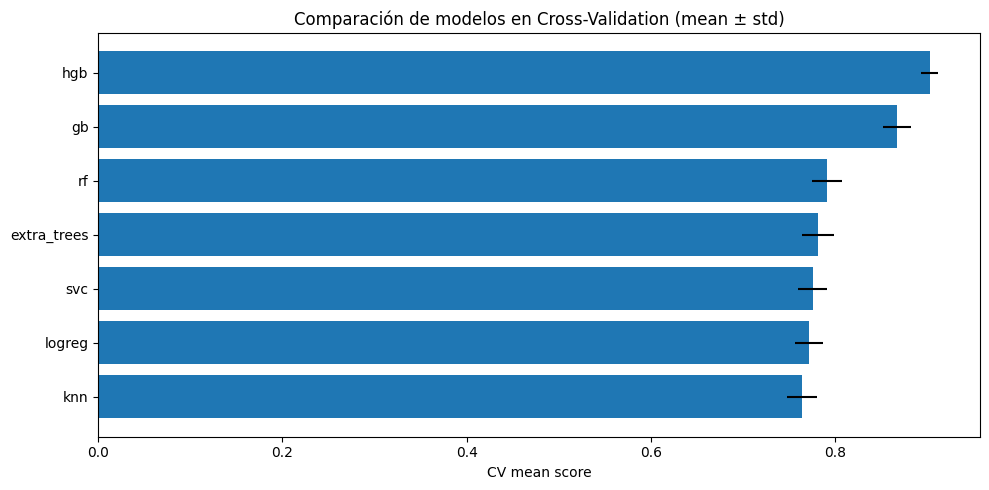

In [5]:
banner("📊 Ranking de modelos (CV)", "Comparación visual con media ± std (métrica principal)", "#ec4899")

if table is None:
    warn("No hay tabla para graficar.")
else:
    metric = "cv_f1_macro_mean"
    metric_std = "cv_f1_macro_std"
    if metric not in table.columns:
        warn(f"No encuentro {metric}. Columnas disponibles: {list(table.columns)}")
    else:
        plot_df = table.sort_values(metric, ascending=True).copy()

        plt.figure(figsize=(10, 5))
        plt.barh(plot_df["model"], plot_df[metric], xerr=plot_df.get(metric_std, None))
        plt.xlabel("CV mean score")
        plt.title("Comparación de modelos en Cross-Validation (mean ± std)")
        plt.tight_layout()
        plt.show()

        ok("Ranking de modelos graficado correctamente.")
        info("Este gráfico es ideal para justificar la selección del mejor modelo.")


# 🧪 Sanity checks del dataset (calidad y consistencia)

Antes de interpretar métricas, se valida que el dataset:

- contiene el target (`target_cls`) sin nulos  
- presenta un **balance razonable** entre clases  
- mantiene consistencia en variables pre-carrera clave (por ejemplo `grid`)  

📌 ¿Por qué esto importa?
Un modelo puede “parecer” bueno si:
- el target está sesgado,
- hay errores de tipado,
- o las variables tienen distribuciones anómalas.

➡️ Estos chequeos aseguran que la evaluación posterior sea **confiable y defendible**.


,count,proportion
target_cls,,
0,5741,0.570
1,4338,0.430


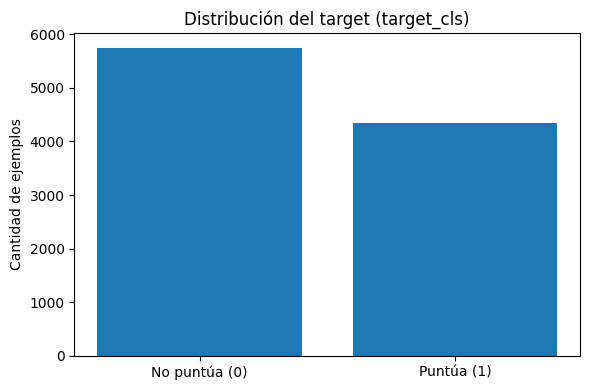

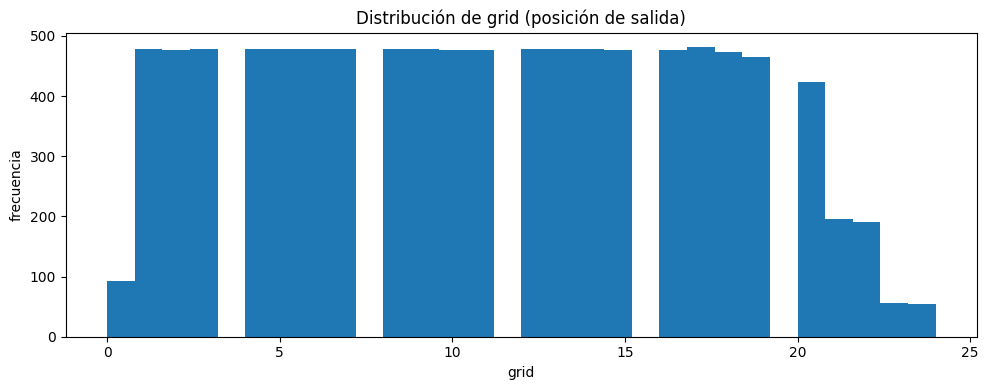

In [13]:
banner("🧪 Sanity checks del dataset", "Balance de clases + distribución de variables pre-carrera", "#10b981")

if df_cls is None:
    warn("No está cargado model_input_classification.csv.")
else:
    # Balance de clases
    if "target_cls" not in df_cls.columns:
        warn("No encuentro target_cls en df_cls.")
    else:
        counts = df_cls["target_cls"].value_counts().sort_index()
        props = df_cls["target_cls"].value_counts(normalize=True).sort_index()

        info(f"Total filas: {len(df_cls):,}")
        display(pd.DataFrame({"count": counts, "proportion": props}).style.format({"proportion":"{:.3f}"}))

        plt.figure(figsize=(6,4))
        plt.bar(["No puntúa (0)", "Puntúa (1)"], counts.values)
        plt.title("Distribución del target (target_cls)")
        plt.ylabel("Cantidad de ejemplos")
        plt.tight_layout()
        plt.show()

        ok("Balance de clases verificado y graficado.")

    # Distribución de grid (muy explicativa)
    if "grid" in df_cls.columns:
        plt.figure(figsize=(10,4))
        plt.hist(df_cls["grid"].dropna(), bins=30)
        plt.title("Distribución de grid (posición de salida)")
        plt.xlabel("grid")
        plt.ylabel("frecuencia")
        plt.tight_layout()
        plt.show()
        ok("Distribución de 'grid' graficada.")


## 🧩 9. Carga del Mejor Modelo (Pipeline) — Artefacto Final

En esta sección cargamos el artefacto persistido **`best_model_classification.pkl`**, que representa el modelo ganador de la fase de selección.

### ✅ Objetivos técnicos
- Verificar que el artefacto cargado corresponde a un **Pipeline** (preprocesamiento + modelo).
- Confirmar que el modelo permite **scoring continuo** (`predict_proba` o `decision_function`) para:
  - ROC / AUC
  - Precision–Recall
  - Análisis de umbral (*threshold analysis*)

> Esto hace que el análisis sea más defendible: no solo “predice”, sino que permite **controlar el trade-off** entre errores.


In [14]:
from pathlib import Path
import pickle
import joblib

banner("🧩 Carga del best_model_classification.pkl", 
       "Verificación del artefacto (Pipeline) + soporte de probabilidades/scores", 
       "#7c3aed")

PROJECT_PATH = Path.cwd().parent  # si tu notebook está en /notebooks, usa: Path.cwd().parent
MODEL_PATH = PROJECT_PATH / "data" / "06_models" / "best_model_classification.pkl"

info(f"Ruta del modelo: <b>{MODEL_PATH}</b>")

if not MODEL_PATH.exists():
    warn("No se encontró el archivo .pkl en la ruta esperada.")
    raise FileNotFoundError(
        f"No existe: {MODEL_PATH}. Ejecuta el pipeline de clasificación o revisa tu catalog.yml."
    )

# Carga robusta (joblib -> pickle)
try:
    best_model = joblib.load(MODEL_PATH)
    ok("Modelo cargado con <b>joblib.load()</b> ✅")
except Exception as e:
    warn(f"joblib falló ({type(e).__name__}). Intentando con pickle...")
    with open(MODEL_PATH, "rb") as f:
        best_model = pickle.load(f)
    ok("Modelo cargado con <b>pickle.load()</b> ✅ (fallback)")

info(f"Tipo del objeto: <b>{type(best_model)}</b>")

# Validaciones útiles
has_steps = hasattr(best_model, "steps")
has_predict = hasattr(best_model, "predict")
has_proba = hasattr(best_model, "predict_proba")
has_decision = hasattr(best_model, "decision_function")

info(f"¿Tiene steps (Pipeline-like)?: <b>{has_steps}</b>")
info(f"¿Tiene predict()?: <b>{has_predict}</b>")
info(f"¿Tiene predict_proba()?: <b>{has_proba}</b>")
info(f"¿Tiene decision_function()?: <b>{has_decision}</b>")

if not has_predict:
    raise TypeError("El objeto cargado no tiene predict(). Revisa el artefacto guardado.")

if has_proba or has_decision:
    ok("El modelo soporta <b>score continuo</b> (ROC/PR/umbral disponibles).")
else:
    warn("El modelo NO soporta predict_proba ni decision_function. ROC/PR/threshold requerirán ajustes.")

ok("Carga y verificación del modelo completadas.")


## 🧪 10. Carga de Dataset + Split Reproducible (Train/Test)

Para evaluar el modelo de forma consistente con el pipeline, replicamos el **mismo esquema**:

- `test_size = 0.2`
- `random_state = 42`
- `stratify = y` (mantiene proporción de clases)

📌 Resultado: obtenemos
- `y_pred` (clase 0/1)
- `y_score` (probabilidad/score continuo) para ROC/PR/umbrales


In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

banner("🧪 Dataset + Split Reproducible", 
       "Cargamos model_input_classification.csv y generamos predicciones + scores", 
       "#2563eb")

DATA_PATH = PROJECT_PATH / "data" / "05_model_input" / "model_input_classification.csv"
info(f"Ruta del dataset: <b>{DATA_PATH}</b>")

if not DATA_PATH.exists():
    warn("No se encontró el dataset model_input_classification.csv en /data/05_model_input/")
    raise FileNotFoundError(f"No existe: {DATA_PATH}")

df = pd.read_csv(DATA_PATH)
ok(f"Dataset cargado: <b>{df.shape[0]:,}</b> filas × <b>{df.shape[1]:,}</b> columnas")

if "target_cls" not in df.columns:
    raise ValueError("El dataset no contiene 'target_cls'. Revisa el node model_input.")

X = df.drop(columns=["target_cls"]).copy()
y = df["target_cls"].astype(int).copy()

TEST_SIZE = 0.2
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

info(f"Train: <b>{len(X_train):,}</b> | Test: <b>{len(X_test):,}</b>")
info(f"Balance Train: <b>{y_train.value_counts(normalize=True).round(3).to_dict()}</b>")
info(f"Balance Test: <b>{y_test.value_counts(normalize=True).round(3).to_dict()}</b>")

# Predicción discreta
y_pred = best_model.predict(X_test)
ok("Predicciones de clase <b>y_pred</b> generadas correctamente ✅")

# Score continuo (para ROC/PR/threshold)
y_score = None
if hasattr(best_model, "predict_proba"):
    y_score = best_model.predict_proba(X_test)[:, 1]
    ok("Score continuo <b>y_score</b> obtenido con predict_proba() ✅")
elif hasattr(best_model, "decision_function"):
    raw = best_model.decision_function(X_test)
    y_score = (raw - raw.min()) / (raw.max() - raw.min() + 1e-12)  # normalización simple
    warn("y_score obtenido con decision_function() y normalizado a [0,1] (aprox).")
else:
    warn("No se pudo obtener y_score (ROC/PR/threshold no disponibles).")

info("<b>Classification Report (Test)</b> — sanity check rápido:")
print(classification_report(y_test, y_pred, digits=4))

ok("Split + predicciones completadas.")


              precision    recall  f1-score   support

           0     0.9246    0.9294    0.9270      1148
           1     0.9060    0.8998    0.9029       868

    accuracy                         0.9167      2016
   macro avg     0.9153    0.9146    0.9150      2016
weighted avg     0.9166    0.9167    0.9166      2016



## 🎯 11. Matriz de Confusión (Conteos + Normalizada)

La matriz de confusión permite entender **qué errores** comete el modelo:

- **Conteos**: número de casos por celda
- **Normalizada**: proporción por clase real (equivalente a recall por fila)

📌 Esto es clave para una defensa académica:
- no depende solo de accuracy
- evidencia sesgos por clase (0 vs 1)


C:\Users\Ignacio\AppData\Local\Temp\ipykernel_5352\3451635245.py:25: UserWarning: Glyph 129518 (\N{ABACUS}) missing from current font.
  plt.tight_layout()
C:\Users\Ignacio\AppData\Local\Temp\ipykernel_5352\3451635245.py:25: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
d:\Programas\Codes for VS code\Proyecto_F1Kedro\proyecto_f1kedro\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 129518 (\N{ABACUS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Programas\Codes for VS code\Proyecto_F1Kedro\proyecto_f1kedro\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


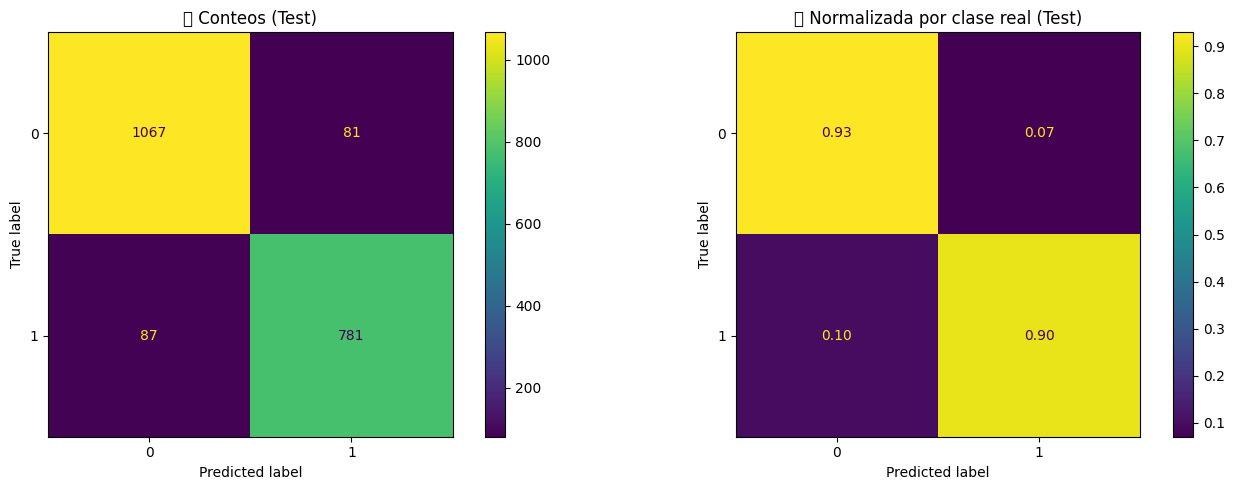

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

banner("🎯 Matriz de Confusión (Test)", 
       "Incluye conteos y versión normalizada por clase real", 
       "#f97316")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    ax=axes[0],
    values_format="d"
)
axes[0].set_title("🧮 Conteos (Test)")

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    ax=axes[1],
    normalize="true",
    values_format=".2f"
)
axes[1].set_title("📊 Normalizada por clase real (Test)")

plt.tight_layout()
plt.show()

ok("Matriz de confusión generada correctamente ✅ (conteos + normalizada).")


## 📈 12. ROC Curve + AUC y Precision–Recall Curve

Estas curvas evalúan el modelo **a través de todos los umbrales posibles**, por eso son altamente defendibles.

### ✅ ROC + AUC
- Trade-off: **TPR (Recall)** vs **FPR**
- Resume separabilidad global con **AUC**

### ✅ Precision–Recall + AP
- Más informativa cuando interesa la clase positiva
- Resume el rendimiento con **Average Precision (AP)**

> Ambas requieren `y_score` (probabilidad o score continuo).


C:\Users\Ignacio\AppData\Local\Temp\ipykernel_5352\2720975615.py:34: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
d:\Programas\Codes for VS code\Proyecto_F1Kedro\proyecto_f1kedro\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


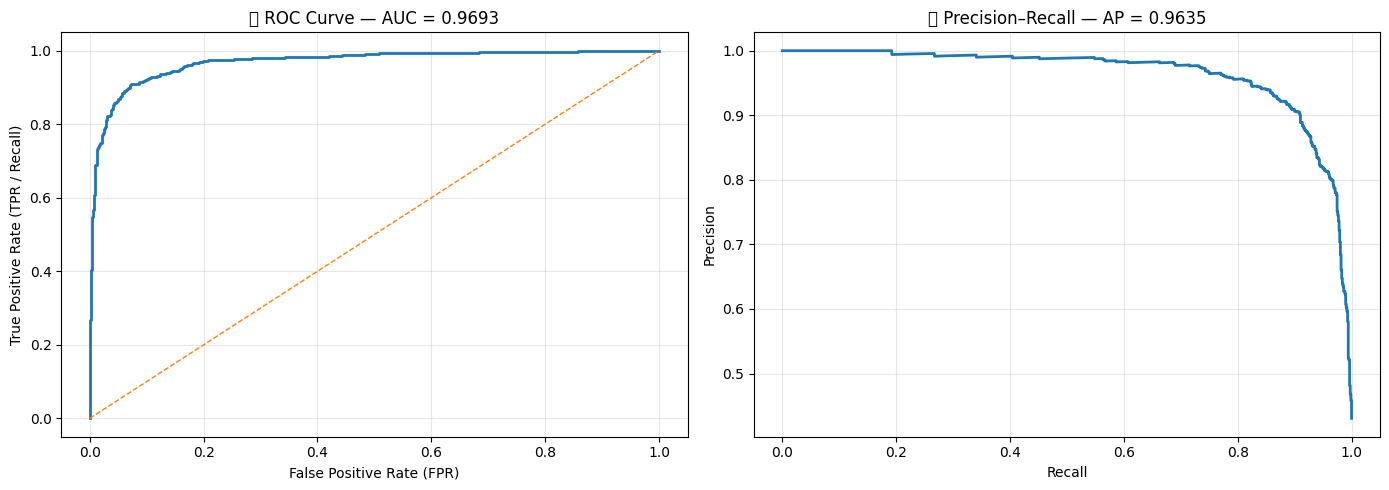

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score

banner("📈 Curvas ROC y Precision–Recall", 
       "Incluye AUC (ROC) y AP (PR) para defensa técnica", 
       "#22c55e")

if y_score is None:
    raise ValueError("No existe y_score. Necesitas predict_proba o decision_function para ROC/PR.")

# ROC
fpr, tpr, _ = roc_curve(y_test, y_score)
auc_roc = roc_auc_score(y_test, y_score)

# PR
prec, rec, _ = precision_recall_curve(y_test, y_score)
ap = average_precision_score(y_test, y_score)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(fpr, tpr, linewidth=2)
axes[0].plot([0, 1], [0, 1], linestyle="--", linewidth=1)
axes[0].set_title(f"📈 ROC Curve — AUC = {auc_roc:.4f}")
axes[0].set_xlabel("False Positive Rate (FPR)")
axes[0].set_ylabel("True Positive Rate (TPR / Recall)")
axes[0].grid(True, alpha=0.3)

axes[1].plot(rec, prec, linewidth=2)
axes[1].set_title(f"📈 Precision–Recall — AP = {ap:.4f}")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

ok(f"Curvas generadas ✅ | AUC={auc_roc:.4f} | AP={ap:.4f}")


## 🧮 13. Threshold Analysis (Precision/Recall/F1 vs Umbral)

Por defecto, se usa un umbral de **0.50** para convertir probabilidad en clase.

Sin embargo, ajustar el umbral permite controlar el trade-off:
- Subir umbral → más precisión, menos recall
- Bajar umbral → más recall, menos precisión

📌 Aquí analizamos cómo cambian:
- Accuracy
- Precision macro
- Recall macro
- F1 macro

y identificamos el **mejor umbral** (según F1 macro).


C:\Users\Ignacio\AppData\Local\Temp\ipykernel_5352\2372047055.py:35: UserWarning: Glyph 129518 (\N{ABACUS}) missing from current font.
  plt.tight_layout()
d:\Programas\Codes for VS code\Proyecto_F1Kedro\proyecto_f1kedro\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 129518 (\N{ABACUS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


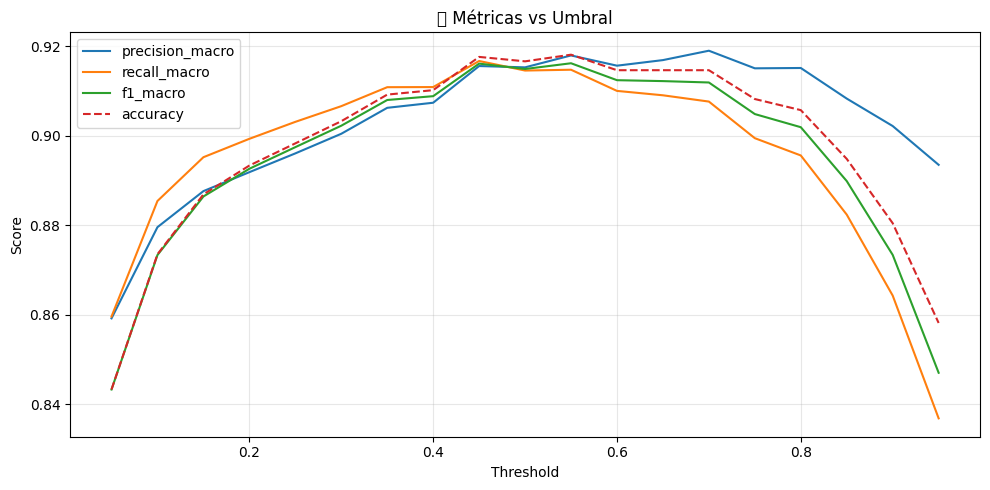

,threshold,accuracy,precision_macro,recall_macro,f1_macro
10,0.55,0.9182,0.9180,0.9148,0.9162
8,0.45,0.9177,0.9156,0.9167,0.9162
9,0.50,0.9167,0.9153,0.9146,0.9150
11,0.60,0.9147,0.9157,0.9101,0.9124
12,0.65,0.9147,0.9169,0.9091,0.9122


In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score

banner("🧮 Threshold Analysis", 
       "Cómo cambian precision/recall/F1 al ajustar el umbral de decisión", 
       "#e11d48")

if y_score is None:
    raise ValueError("No existe y_score. No se puede analizar umbrales.")

thresholds = np.linspace(0.05, 0.95, 19)

rows = []
for th in thresholds:
    y_hat = (y_score >= th).astype(int)
    rows.append({
        "threshold": th,
        "accuracy": (y_hat == y_test).mean(),
        "precision_macro": precision_score(y_test, y_hat, average="macro", zero_division=0),
        "recall_macro": recall_score(y_test, y_hat, average="macro", zero_division=0),
        "f1_macro": f1_score(y_test, y_hat, average="macro", zero_division=0),
    })

th_df = pd.DataFrame(rows)

plt.figure(figsize=(10, 5))
plt.plot(th_df["threshold"], th_df["precision_macro"], label="precision_macro")
plt.plot(th_df["threshold"], th_df["recall_macro"], label="recall_macro")
plt.plot(th_df["threshold"], th_df["f1_macro"], label="f1_macro")
plt.plot(th_df["threshold"], th_df["accuracy"], label="accuracy", linestyle="--")
plt.title("🧮 Métricas vs Umbral")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

top5 = th_df.sort_values("f1_macro", ascending=False).head(5)
info("Top 5 umbrales según <b>F1 macro</b> (recomendación defendible):")
display(top5.style.format({
    "threshold": "{:.2f}",
    "accuracy": "{:.4f}",
    "precision_macro": "{:.4f}",
    "recall_macro": "{:.4f}",
    "f1_macro": "{:.4f}",
}))

best_row = th_df.loc[th_df["f1_macro"].idxmax()]
ok(f"Mejor umbral por F1_macro: <b>{best_row['threshold']:.2f}</b> | F1={best_row['f1_macro']:.4f} | Acc={best_row['accuracy']:.4f}")


## 🔎 14. Permutation Importance (Top 15)

La Permutation Importance mide cuánto **cae el desempeño** cuando una variable se desordena.

✅ Ventajas académicas:
- Funciona con cualquier modelo
- Es robusta para pipelines
- Interpreta importancia respecto a una métrica objetivo

📌 Usaremos como métrica: **F1 macro**, alineada con la selección del modelo.


C:\Users\Ignacio\AppData\Local\Temp\ipykernel_5352\2736140342.py:34: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
d:\Programas\Codes for VS code\Proyecto_F1Kedro\proyecto_f1kedro\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


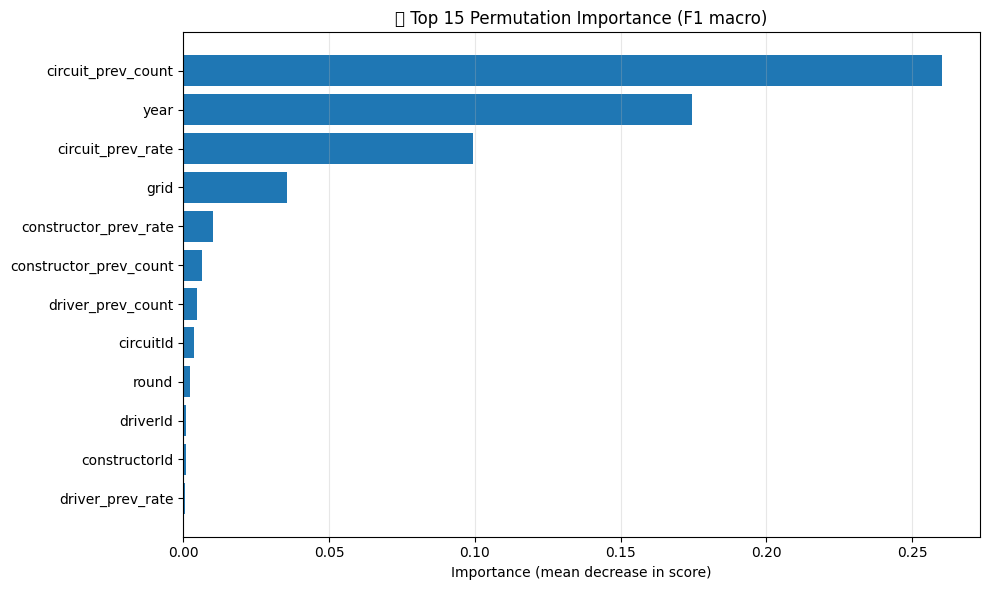

,feature,importance_mean,importance_std
11,circuit_prev_count,0.260234,0.007958
1,year,0.174407,0.010327
10,circuit_prev_rate,0.099180,0.005862
0,grid,0.035692,0.003158
8,constructor_prev_rate,0.010123,0.002859
9,constructor_prev_count,0.006295,0.001435
7,driver_prev_count,0.004802,0.002239
3,circuitId,0.003574,0.002811
2,round,0.002445,0.001675
4,driverId,0.000963,0.001998


In [19]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer

banner("🔎 Permutation Importance (Top 15)", 
       "Explica qué variables tienen mayor impacto en el desempeño del modelo", 
       "#0ea5e9")

f1_macro_scorer = make_scorer(f1_score, average="macro", zero_division=0)

info(f"Tamaño del set usado: <b>{X_test.shape[0]:,}</b> filas (Test)")

pi = permutation_importance(
    best_model,
    X_test, y_test,
    scoring=f1_macro_scorer,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

imp = pd.DataFrame({
    "feature": X_test.columns,
    "importance_mean": pi.importances_mean,
    "importance_std": pi.importances_std
}).sort_values("importance_mean", ascending=False)

top15 = imp.head(15).copy()

plt.figure(figsize=(10, 6))
plt.barh(top15["feature"][::-1], top15["importance_mean"][::-1])
plt.title("🔎 Top 15 Permutation Importance (F1 macro)")
plt.xlabel("Importance (mean decrease in score)")
plt.grid(True, axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

display(top15.style.format({"importance_mean": "{:.6f}", "importance_std": "{:.6f}"}))

ok("Permutation importance calculada y graficada correctamente ✅")


## 🧠 15. Interpretación Académica del Modelo

### ✅ ¿Qué significa este desempeño?
Los resultados en **CV** y **Test** sugieren que el modelo:
- generaliza correctamente (sin colapsar fuera del entrenamiento)
- mantiene equilibrio entre clases (F1 macro / normalización)

### ✅ ¿Por qué es defendible?
- Features **pre-carrera** (anti-leakage)
- CV estratificada **k ≥ 5**
- Métricas múltiples (no solo accuracy)
- Curvas ROC/PR: evalúan todos los umbrales
- Threshold analysis: demuestra control de riesgo

### 🔎 ¿Qué variables “mandan”?
Permutation importance permite explicar qué factores dominan la predicción,
y justificar que el modelo utiliza señales consistentes con el contexto deportivo.

### ⚠️ Limitaciones
- Cambios temporales/reglamentarios (concept drift)
- IDs pueden capturar historia (patrones) sin causalidad
- Umbral 0.50 no siempre es óptimo según objetivo del negocio/evaluación
- Resultados dependen de la ventana histórica usada (min_year, cutoff, etc.)


In [21]:
# =========================================================
# ✅ Evaluación de TODOS los modelos + Mejor Modelo (explícito)
# =========================================================
from __future__ import annotations

from pathlib import Path
import ast
import json
import pandas as pd
import numpy as np

from IPython.display import display, HTML

# --- helpers visuales (usa los tuyos si ya existen) ---
if "banner" not in globals():
    def banner(title: str, subtitle: str | None = None, color: str = "#2563eb"):
        subtitle_html = f"<div style='opacity:.85;font-size:14px;margin-top:4px'>{subtitle}</div>" if subtitle else ""
        html = f"""
        <div style="
            border-left: 10px solid {color};
            background: #0b1220;
            color: #e5e7eb;
            padding: 14px 16px;
            border-radius: 12px;
            margin: 10px 0 14px 0;
            font-family: ui-sans-serif, system-ui;">
            <div style="font-size:18px;font-weight:700;">{title}</div>
            {subtitle_html}
        </div>
        """
        display(HTML(html))

if "ok" not in globals():
    def ok(msg: str):
        display(HTML(f"<div style='padding:10px 12px;border-radius:10px;background:#052e16;color:#d1fae5;border:1px solid #14532d'>✅ {msg}</div>"))
if "info" not in globals():
    def info(msg: str):
        display(HTML(f"<div style='padding:10px 12px;border-radius:10px;background:#0b1220;color:#e5e7eb;border:1px solid #1f2937'>ℹ️ {msg}</div>"))
if "warn" not in globals():
    def warn(msg: str):
        display(HTML(f"<div style='padding:10px 12px;border-radius:10px;background:#2b1d0e;color:#fde68a;border:1px solid #92400e'>⚠️ {msg}</div>"))

def _fmt(x, nd=4):
    try:
        return f"{float(x):.{nd}f}"
    except Exception:
        return str(x)

banner(
    "🏁 Evaluación de Modelos — Selección del Mejor (Explícita)",
    "Leemos classification_metrics_table.csv y reportamos el top-1 con métricas CV/Test",
    "#f97316"
)

# --- Rutas ---
PROJECT_PATH = globals().get("PROJECT_PATH", None)
if PROJECT_PATH is None:
    PROJECT_PATH = Path.cwd().parent
PROJECT_PATH = Path(PROJECT_PATH)

DATA_REPORTING = PROJECT_PATH / "data" / "08_reporting"
DATA_MODELS = PROJECT_PATH / "data" / "06_models"

metrics_csv = DATA_REPORTING / "classification_metrics_table.csv"
summary_json = DATA_REPORTING / "classification_metrics_summary.json"
best_pkl = DATA_MODELS / "best_model_classification.pkl"

info(f"Ruta metrics table: <b>{metrics_csv}</b>")
info(f"Ruta summary JSON : <b>{summary_json}</b>")
info(f"Ruta best model PKL: <b>{best_pkl}</b>")

if not metrics_csv.exists():
    raise FileNotFoundError(f"No existe: {metrics_csv}. Ejecuta el pipeline de clasificación para generarlo.")

results = pd.read_csv(metrics_csv)

# --- Criterio de orden ---
order_by = "cv_f1_macro_mean"
if "modeling" in globals() and isinstance(modeling, dict):
    order_by = str(modeling.get("order_by", order_by))
if order_by not in results.columns:
    warn(f"order_by='{order_by}' no existe. Usando 'cv_f1_macro_mean'.")
    order_by = "cv_f1_macro_mean"

# --- Ranking ---
results_ranked = results.sort_values(by=order_by, ascending=False).reset_index(drop=True)
top = results_ranked.iloc[0].to_dict()

best_name = str(top.get("model", "N/A"))
best_smote = bool(top.get("use_smote", False))
best_params_raw = top.get("best_params", "{}")

# parse params bonito
try:
    best_params_dict = ast.literal_eval(best_params_raw) if isinstance(best_params_raw, str) else dict(best_params_raw)
    if not isinstance(best_params_dict, dict):
        best_params_dict = {"raw": str(best_params_raw)}
except Exception:
    best_params_dict = {"raw": str(best_params_raw)}

# --- Mensaje explícito (lo que pediste) ---
display(HTML(f"""
<div style="margin-top:8px;padding:12px 14px;border-radius:12px;background:#111827;border:1px solid #1f2937;color:#e5e7eb">
  <div style="font-size:18px;font-weight:900;">
    🏆 Mejor modelo seleccionado (Top-1): <span style="color:#fbbf24">{best_name}</span>
  </div>
  <div style="margin-top:6px;opacity:.9">
    Criterio de selección: <b style="color:#93c5fd">{order_by}</b> &nbsp; | &nbsp; SMOTE aplicado: <b>{best_smote}</b>
  </div>
</div>
"""))

# --- Tarjeta con métricas clave ---
card = f"""
<div style="background:#0b1220;border:1px solid #1f2937;border-radius:14px;padding:14px 16px;margin-top:10px">
  <div style="font-size:15px;font-weight:800;color:#e5e7eb;">📌 Métricas del mejor modelo (CV y Test)</div>

  <div style="margin-top:10px;display:grid;grid-template-columns:repeat(4,minmax(0,1fr));gap:10px;">
    <div style="background:#111827;border:1px solid #1f2937;border-radius:12px;padding:10px">
      <div style="opacity:.75;color:#e5e7eb">CV Accuracy</div>
      <div style="font-size:18px;font-weight:800;color:#e5e7eb">{_fmt(top.get("cv_accuracy_mean"))}</div>
      <div style="opacity:.7;color:#e5e7eb">± {_fmt(top.get("cv_accuracy_std"))}</div>
    </div>
    <div style="background:#111827;border:1px solid #1f2937;border-radius:12px;padding:10px">
      <div style="opacity:.75;color:#e5e7eb">CV F1 macro</div>
      <div style="font-size:18px;font-weight:800;color:#e5e7eb">{_fmt(top.get("cv_f1_macro_mean"))}</div>
      <div style="opacity:.7;color:#e5e7eb">± {_fmt(top.get("cv_f1_macro_std"))}</div>
    </div>
    <div style="background:#111827;border:1px solid #1f2937;border-radius:12px;padding:10px">
      <div style="opacity:.75;color:#e5e7eb">Test Accuracy</div>
      <div style="font-size:18px;font-weight:800;color:#e5e7eb">{_fmt(top.get("test_accuracy"))}</div>
    </div>
    <div style="background:#111827;border:1px solid #1f2937;border-radius:12px;padding:10px">
      <div style="opacity:.75;color:#e5e7eb">Test F1 macro</div>
      <div style="font-size:18px;font-weight:800;color:#e5e7eb">{_fmt(top.get("test_f1_macro"))}</div>
    </div>
  </div>

  <div style="margin-top:10px;opacity:.92;color:#e5e7eb">
    <b>CV Precision macro:</b> {_fmt(top.get("cv_precision_macro_mean"))} &nbsp; | &nbsp;
    <b>CV Recall macro:</b> {_fmt(top.get("cv_recall_macro_mean"))} <br>
    <b>Gap generalización (F1):</b> {_fmt(top.get("generalization_gap_f1"))} (train_f1 - cv_f1)
  </div>

  <div style="margin-top:10px;background:#111827;border:1px solid #1f2937;border-radius:12px;padding:10px;color:#e5e7eb">
    <div style="font-weight:800;margin-bottom:6px">⚙️ Best Params (GridSearch)</div>
    <pre style="margin:0;white-space:pre-wrap;word-break:break-word;color:#e5e7eb">{json.dumps(best_params_dict, indent=2, ensure_ascii=False)}</pre>
  </div>
</div>
"""
display(HTML(card))
ok("Mejor modelo reportado explícitamente con métricas y parámetros.")

# --- Tabla estilizada (top-10) ---
cols_show = [
    "model","use_smote",
    "cv_accuracy_mean","cv_accuracy_std",
    "cv_precision_macro_mean","cv_recall_macro_mean","cv_f1_macro_mean","cv_f1_macro_std",
    "generalization_gap_f1",
    "test_accuracy","test_precision_macro","test_recall_macro","test_f1_macro",
    "best_params"
]
cols_show = [c for c in cols_show if c in results_ranked.columns]

top10 = results_ranked[cols_show].head(10).copy()

metric_cols = [c for c in top10.columns if any(k in c for k in ["cv_", "test_", "gap"]) and top10[c].dtype != "O"]
for c in metric_cols:
    top10[c] = top10[c].map(lambda x: float(x))

styler = (
    top10.style
    .format({c: "{:.4f}" for c in metric_cols})
    .set_properties(**{"background-color":"#0b1220","color":"#e5e7eb","border-color":"#1f2937"})
    .set_table_styles([
        {"selector":"th", "props":[("background-color","#111827"),("color","#e5e7eb"),("border-color","#1f2937")]},
        {"selector":"td", "props":[("border-color","#1f2937")]},
    ])
)

for bar_col in [c for c in ["cv_f1_macro_mean","cv_accuracy_mean"] if c in top10.columns][:2]:
    styler = styler.bar(subset=[bar_col], align="mid")

styler = styler.apply(
    lambda s: ["background-color:#052e16;border:1px solid #14532d"]*len(s) if s.name==0 else [""]*len(s),
    axis=1
)

display(HTML("<div style='margin-top:12px;font-weight:800;color:#e5e7eb'>📋 Top-10 modelos (ranking)</div>"))
display(styler)

# --- Consistencia con JSON (si existe) ---
if summary_json.exists():
    with open(summary_json, "r", encoding="utf-8") as f:
        summary = json.load(f)

    json_best = summary.get("best_model", None)
    json_crit = summary.get("selection_criterion", None)

    if json_best is not None and str(json_best) != best_name:
        warn(f"Atención: el JSON dice best_model='{json_best}' pero la tabla top-1 es '{best_name}'. Revisa order_by o cómo se generó el summary.")
    else:
        ok(f"Consistente con JSON: best_model='{json_best}' | selection_criterion='{json_crit}'")
else:
    info("No se encontró classification_metrics_summary.json (opcional).")

# --- Verificación PKL (opcional) ---
if best_pkl.exists():
    try:
        import joblib
        model = joblib.load(best_pkl)
        info(f"PKL cargado OK. Tipo: <b>{type(model)}</b>")
        has_predict = hasattr(model, "predict")
        has_proba = hasattr(model, "predict_proba")
        has_decision = hasattr(model, "decision_function")
        info(f"Compatibilidad: predict={has_predict} | predict_proba={has_proba} | decision_function={has_decision}")
        ok("Artefacto PKL validado (carga + métodos).")
    except Exception as e:
        warn(f"PKL existe pero falló la carga con joblib: {e}")
else:
    warn("No encontré best_model_classification.pkl (si entrenaste, revisa data/06_models).")


,model,use_smote,cv_accuracy_mean,cv_accuracy_std,cv_precision_macro_mean,cv_recall_macro_mean,cv_f1_macro_mean,cv_f1_macro_std,generalization_gap_f1,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro,best_params
0,hgb,False,0.9044,0.0089,0.9024,0.9029,0.9026,0.0090,0.0974,0.9167,0.9153,0.9146,0.9150,"{'model__l2_regularization': 1.0, 'model__learning_rate': 0.1, 'model__max_depth': None, 'model__max_iter': 800, 'model__min_samples_leaf': 20}"
1,gb,False,0.8692,0.0150,0.8665,0.8671,0.8667,0.0152,0.0618,0.8745,0.8718,0.8727,0.8722,"{'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 400, 'model__subsample': 1.0}"
2,rf,True,0.7931,0.0162,0.7896,0.7934,0.7907,0.0162,0.1024,0.8051,0.8013,0.8049,0.8026,"{'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 600}"
3,extra_trees,True,0.7836,0.0170,0.7803,0.7844,0.7812,0.0170,0.0959,0.7912,0.7879,0.7923,0.7890,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 600}"
4,svc,True,0.7776,0.0160,0.7746,0.7790,0.7754,0.0159,0.0582,0.7902,0.7876,0.7926,0.7884,"{'model__C': 2.0, 'model__kernel': 'rbf'}"
5,logreg,True,0.7738,0.0154,0.7706,0.7749,0.7715,0.0154,0.0054,0.7738,0.7709,0.7754,0.7717,"{'model__C': 0.1, 'model__solver': 'lbfgs'}"
6,knn,True,0.7651,0.0164,0.7657,0.7709,0.7641,0.0164,0.0151,0.7758,0.7770,0.7823,0.7749,"{'model__n_neighbors': 31, 'model__weights': 'uniform'}"


## 📌 16. Conclusiones Finales

<div style="padding:14px; border-radius:14px; background:#0b1220; color:#e5e7eb; border:1px solid #334155;">
<b>✅ Conclusión técnica (pendiente de redacción final):</b><br><br>

Cuando me compartas tus resultados finales (por ejemplo: AUC/AP, mejor umbral y top features),
redacto aquí una conclusión de nivel informe que incluya:

<ul>
<li>📊 desempeño final (CV y Test) con números</li>
<li>🎯 lectura de matriz de confusión (errores relevantes)</li>
<li>📈 interpretación ROC/PR y utilidad práctica</li>
<li>🧮 recomendación de umbral según objetivo</li>
<li>🔎 explicación basada en permutation importance</li>
<li>⚠️ limitaciones y líneas de mejora</li>
</ul>
</div>
